In [1]:
from chainmap import ChainMap
from torch.autograd import Variable
import librosa
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data

from manage_audio import AudioPreprocessor
import librosa.display
import matplotlib.pyplot as plt

In [2]:
#########
# implemented by wj
def fft_to_obtain_tf(x1,x2):
    sample_rate = 16000
    window = 'hann'
    n_fft = 480
    win_length = n_fft
    hop_length = 160
    
    r1 = 4*sample_rate - 1
    r2 = 304*sample_rate
    
    y1 = librosa.core.load(x1, sr=16000)[0]
    y2 = librosa.core.load(x2, sr=16000)[0]
    y1 = y1 - y1.mean()
    y2 = y2 - y2.mean()

    # STFT
    FFT1 = librosa.stft(y1[r1:r2], n_fft=n_fft, hop_length=hop_length,
                     win_length=win_length, window=window)
    print("FFT1 shape: ",FFT1.shape)
    FFT1_abs = np.abs(FFT1)
    FFT1_mean = np.mean(FFT1_abs,axis=1)
    
    FFT2 = librosa.stft(y2[r1:r2], n_fft=n_fft, hop_length=hop_length,
                     win_length=win_length, window=window)
    FFT2_abs = np.abs(FFT2)
    FFT2_mean = np.mean(FFT2_abs,axis=1)
    
    TF = np.divide(FFT2_mean,FFT1_mean)
    return TF[:,None]/TF.max()
# no normalization
def obtain_tf_no_norm(x1,x2):
    sample_rate = 16000
    window = 'hann'
    n_fft = 480
    win_length = n_fft
    hop_length = 160

    r1 = 4*sample_rate - 1
    r2 = 304*sample_rate
    
    y1 = librosa.core.load(x1, sr=16000)[0]
    y2 = librosa.core.load(x2, sr=16000)[0]
    y1 = y1 - y1.mean()
    y2 = y2 - y2.mean()    
    # STFT
    FFT1 = librosa.stft(y1[r1:r2], n_fft=n_fft, hop_length=hop_length,
                     win_length=win_length, window=window)
    FFT1_abs = np.abs(FFT1)
    FFT1_mean = np.mean(FFT1_abs,axis=1)
    
    FFT2 = librosa.stft(y2[r1:r2], n_fft=n_fft, hop_length=hop_length,
                     win_length=win_length, window=window)
    FFT2_abs = np.abs(FFT2)
    FFT2_mean = np.mean(FFT2_abs,axis=1)
    
    TF = np.divide(FFT2_mean,FFT1_mean)
    return TF

def obtain_tf_usb(x1,x2):
    tf = obtain_tf_no_norm(x1,x2)
    tf[:5] = 0
    return tf[:,None]/tf.max()

def stft_ave_no_DC(x):
    sample_rate = 16000
    window = 'hann'
    n_fft = 480
    win_length = n_fft
    hop_length = 160
    
    normalize = 'True'
    r1 = 4*sample_rate - 1
    r2 = 304*sample_rate
    
    y = librosa.core.load(x, sr=16000)[0]
    y -= y.mean()
    
    # STFT
    FFT = librosa.stft(y[r1:r2], n_fft=n_fft, hop_length=hop_length,
                     win_length=win_length, window=window)
    FFT_abs = np.abs(FFT)
    FFT_mean = np.mean(FFT_abs,axis=1)

    return FFT_mean[:,None]/FFT_mean.max()

## load audio

In [3]:
file_data = "../speech_dataset/yes/834f03fe_nohash_0.wav"
in_len = 16000 #1s=16000Hz
data = librosa.core.load(file_data, sr=16000)[0]
# pad data with 0s if less than 1s
data = np.pad(data, (0, max(0, in_len - len(data))), "constant")

In [4]:
print(f'len of data {len(data)}, padded 0 = {in_len - len(data)}')

len of data 16000, padded 0 = 0


In [5]:
d = data.reshape(1,-1,40)
print(d.shape)

(1, 400, 40)


In [6]:
audio_processor = AudioPreprocessor(n_mels=40, n_dct_filters=40, hop_ms=10)

In [7]:
audio_tensor = torch.from_numpy(audio_processor.compute_mfccs(data).reshape(1,-1,40))
audio_tensor.shape

torch.Size([1, 101, 40])

### Librosa library to compute MFCC from time series data input

In [8]:
# mfcc_from_audio = librosa.feature.mfcc(y = librosa.core.load(file_data, sr=16000)[0], sr=16000, n_fft=480,hop_length=16000 // 1000*hop_ms,n_mfcc=40,fmin=20,fmax=4000)
y,sr = librosa.core.load(file_data,sr=16000)
hop_ms = 10
mfcc_from_audio = librosa.feature.melspectrogram(y=y,
                                                 sr=16000,
                                                 n_fft=480,
                                                 n_mels=40, 
                                                 hop_length=16000 // 1000*hop_ms,
                                                 fmin=20,
                                                 fmax=4000)

# data = [np.matmul(40, x) for x in np.split(mfcc_from_audio, mfcc_from_audio.shape[1], axis=1)]
# data = np.array(data, order="F").astype(np.float32)


print(y.shape, mfcc_from_audio.shape)
# plt.figure(figsize=(10, 4))
# librosa.display.specshow(mfcc_from_audio, x_axis='time')
# plt.colorbar()
# plt.title('MFCC')
# plt.tight_layout()
# plt.show()

(16000,) (40, 101)


### compute from STFT

In [9]:
D = np.abs(librosa.stft(y,n_fft=480,hop_length=16000 // 1000*hop_ms))**2
# S = np.abs(stft(y, n_fft=n_fft, hop_length=hop_length,
#                 win_length=win_length, center=center,
#                 window=window, pad_mode=pad_mode))**power
mfcc_from_stft = librosa.feature.melspectrogram(S=D,sr=sr,fmin=20,fmax=4000,n_mels=40)
print('D shape is ',D.shape,'mfcc_from_stft: ',mfcc_from_stft.shape)

D shape is  (241, 101) mfcc_from_stft:  (40, 101)


In [10]:
print('mfcc_from_audio: ',mfcc_from_audio.shape)
print('mfcc_from_stft: ',mfcc_from_stft.shape)

mfcc_from_audio:  (40, 101)
mfcc_from_stft:  (40, 101)


In [11]:
print(mfcc_from_audio)

[[8.48927153e-05 1.14961616e-04 2.23576849e-04 ... 2.98096314e-04
  1.67167910e-04 6.75719060e-05]
 [2.67733915e-05 1.33207382e-05 3.77890135e-05 ... 3.89414109e-05
  3.34360434e-05 2.74572130e-05]
 [1.04294118e-05 6.23694835e-06 1.68793542e-05 ... 3.33082724e-05
  2.43904190e-05 4.50995464e-06]
 ...
 [1.58153090e-07 8.26728139e-08 5.77308737e-08 ... 3.04608037e-07
  1.83972313e-07 3.10630168e-07]
 [2.11927209e-07 1.60246905e-07 6.54426109e-08 ... 2.30065555e-07
  1.68758880e-07 1.36758565e-07]
 [3.71342753e-07 2.08993476e-07 6.58357908e-08 ... 5.15745669e-07
  6.44651458e-07 5.25450417e-07]]


In [12]:
print(mfcc_from_stft)

[[8.48927153e-05 1.14961616e-04 2.23576849e-04 ... 2.98096314e-04
  1.67167910e-04 6.75719060e-05]
 [2.67733915e-05 1.33207382e-05 3.77890135e-05 ... 3.89414109e-05
  3.34360434e-05 2.74572130e-05]
 [1.04294118e-05 6.23694835e-06 1.68793542e-05 ... 3.33082724e-05
  2.43904190e-05 4.50995464e-06]
 ...
 [1.58153090e-07 8.26728139e-08 5.77308737e-08 ... 3.04608037e-07
  1.83972313e-07 3.10630168e-07]
 [2.11927209e-07 1.60246905e-07 6.54426109e-08 ... 2.30065555e-07
  1.68758880e-07 1.36758565e-07]
 [3.71342753e-07 2.08993476e-07 6.58357908e-08 ... 5.15745669e-07
  6.44651458e-07 5.25450417e-07]]


In [13]:
## modify from here
flist = [
    "/data1/wenjie/github/deepspeech.pytorch/data/audio/TR2_loc1/white-noise-true-20min.wav",
    "/data1/wenjie/github/honk/speech_dataset_wenjie/meetingroom/loc2-45cm-10cmd/white-noise/convert/ATR-white.wav",
    "/data1/wenjie/github/honk/speech_dataset_wenjie/meetingroom/loc2-45cm-10cmd/white-noise/convert/clipon-white.wav",
    "/data1/wenjie/github/honk/speech_dataset_wenjie/meetingroom/loc2-45cm-10cmd/white-noise/convert/maono-white.wav",
    "/data1/wenjie/github/honk/speech_dataset_wenjie/meetingroom/loc2-45cm-10cmd/white-noise/convert/USB-white.wav",
    "/data1/wenjie/github/honk/speech_dataset_wenjie/meetingroom/loc2-45cm-10cmd/white-noise/convert/USBplug-white.wav",
    "/data1/wenjie/github/deepspeech.pytorch/librispeech/test_wj/converted/Meeting-room/loc1-iph7/convert/ATR-silence.wav",
    "/data1/wenjie/github/deepspeech.pytorch/librispeech/test_wj/converted/Meeting-room/loc1-iph7/convert/clipon-silence.wav",
    "/data1/wenjie/github/deepspeech.pytorch/librispeech/test_wj/converted/Meeting-room/loc1-iph7/convert/maono-silence.wav",
    "/data1/wenjie/github/deepspeech.pytorch/librispeech/test_wj/converted/Meeting-room/loc1-iph7/convert/USB-silence.wav",
    "/data1/wenjie/github/deepspeech.pytorch/librispeech/test_wj/converted/Meeting-room/loc1-iph7/convert/USBplug-silence.wav"
    ]
def fft_to_obtain_inverse_tf(x1,x2):
    sample_rate = 16000
    window = 'hann'
    n_fft = 480
    win_length = n_fft
    hop_length = 160
    
    r1 = 4*sample_rate - 1
    r2 = 304*sample_rate
    
    y1 = librosa.core.load(x1, sr=16000)[0]
    y2 = librosa.core.load(x2, sr=16000)[0]
    y1 = y1 - y1.mean()
    y2 = y2 - y2.mean()

    # STFT
    FFT1 = librosa.stft(y1[r1:r2], n_fft=n_fft, hop_length=hop_length,
                     win_length=win_length, window=window)
    print("FFT1 shape: ",FFT1.shape)
    FFT1_abs = np.abs(FFT1)
    FFT1_mean = np.mean(FFT1_abs,axis=1)
    FFT1_mean = FFT1_mean/FFT1_mean.max()
    
    FFT2 = librosa.stft(y2[r1:r2], n_fft=n_fft, hop_length=hop_length,
                     win_length=win_length, window=window)
    FFT2_abs = np.abs(FFT2)
    FFT2_mean = np.mean(FFT2_abs,axis=1)
    FFT2_mean = FFT2_mean/FFT2_mean.max()
    
    TF = np.divide(FFT1_mean,FFT2_mean)
    return TF[:,None]
# tf_atr = fft_to_obtain_tf(flist[0],flist[1]) + stft_ave_no_DC(flist[6])
# tf_clipon = obtain_tf_usb(flist[0],flist[2]) + stft_ave_no_DC(flist[7]) # obtain transfer function
# tf_maono = fft_to_obtain_tf(flist[0],flist[3]) + stft_ave_no_DC(flist[8]) # obtain transfer function
# tf_USB = obtain_tf_usb(flist[0],flist[4]) + stft_ave_no_DC(flist[9]) # obtain transfer function
# tf_USBplug = obtain_tf_usb(flist[0],flist[5]) + stft_ave_no_DC(flist[10]) # obtain transfer function

tf_atr = fft_to_obtain_inverse_tf(flist[0],flist[1]) #+ stft_ave_no_DC(flist[6])
tf_clipon = fft_to_obtain_inverse_tf(flist[0],flist[2]) #+ stft_ave_no_DC(flist[7])
tf_maono = fft_to_obtain_inverse_tf(flist[0],flist[3]) #+ stft_ave_no_DC(flist[8])
tf_USB = fft_to_obtain_inverse_tf(flist[0],flist[4]) #+ stft_ave_no_DC(flist[9])
tf_USBplug = fft_to_obtain_inverse_tf(flist[0],flist[5]) #+ stft_ave_no_DC(flist[10])


FFT1 shape:  (241, 30001)
FFT1 shape:  (241, 30001)
FFT1 shape:  (241, 30001)
FFT1 shape:  (241, 30001)
FFT1 shape:  (241, 30001)


In [14]:
tf_atr.shape

(241, 1)

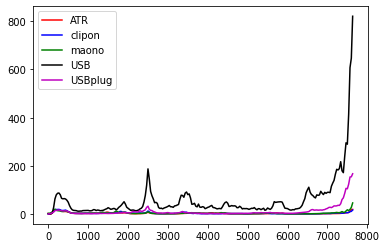

In [15]:
f = np.linspace(0,1,241)*16000/2
tf = [tf_atr,tf_clipon,tf_maono,tf_USB,tf_USBplug]
# plt.plot(f,tf[index],'r',label=index)
plt.plot(f[0:230],tf[0][0:230],'r',label='ATR')
plt.plot(f[0:230],tf[1][0:230],'b',label='clipon')
plt.plot(f[0:230],tf[2][0:230],'g',label='maono')
plt.plot(f[0:230],tf[3][0:230],'k',label='USB')
plt.plot(f[0:230],tf[4][0:230],'m',label='USBplug')
plt.legend()
plt.show()

In [151]:
new_tf = np.concatenate((f.reshape(-1,1),
                         tf_atr.reshape(-1,1),
                         tf_clipon.reshape(-1,1),
                         tf_maono.reshape(-1,1),
                         tf_USB.reshape(-1,1),
                         tf_USBplug.reshape(-1,1)),
                         axis=1)

In [152]:
new_tf.shape
np.savetxt("mic-tf.csv", new_tf, delimiter=",",fmt='%.4e')

In [155]:
#mfcc_from_stft_new = librosa.feature.melspectrogram(S=new_D,sr=sr,fmin=20,fmax=4000,n_mels=40)
#print(mfcc_from_stft_new.shape)

In [156]:
arr = np.array([2,3,4])
mean = arr.mean()
std = arr.std()
print(f'mean {mean}, mean = {std}')

mean 3.0, mean = 0.816496580927726


In [157]:
arr_nor = (arr - mean)/std
print(arr_nor)

[-1.22474487  0.          1.22474487]


In [158]:
y1 = librosa.core.load(flist[0], sr=16000)[0]

In [159]:
tf_atr = fft_to_obtain_tf(flist[0],flist[1])

FFT1 shape:  (241, 30001)


In [160]:
a = np.array([1,2,3])
b = np.array([4,2,3])
c = a/b
print(c)

[0.25 1.   1.  ]


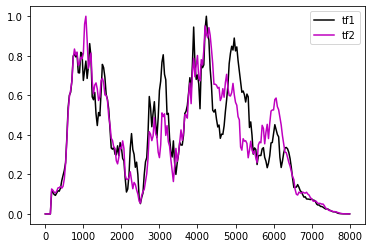

In [161]:
flist = [
    "/data1/wenjie/github/deepspeech.pytorch/data/audio/TR2_loc1/white-noise-true-20min.wav",
    "/data1/wenjie/github/honk/speech_dataset_wenjie/meetingroom/loc2-45cm/white-noise/convert/USB-white.wav",
    "/data1/wenjie/github/honk/speech_dataset_wenjie/meetingroom/loc2-45cm/white-noise/convert/USBplug-white.wav",
    "/data1/wenjie/github/honk/speech_dataset_wenjie/meetingroom/loc2-45cm-10cmd/white-noise/convert/USB-white.wav",
    "/data1/wenjie/github/honk/speech_dataset_wenjie/meetingroom/loc2-45cm-10cmd/white-noise/convert/USBplug-white.wav",
    "/data1/wenjie/github/deepspeech.pytorch/librispeech/test_wj/converted/Meeting-room/loc1-iph7/convert/ATR-silence.wav",
    "/data1/wenjie/github/deepspeech.pytorch/librispeech/test_wj/converted/Meeting-room/loc1-iph7/convert/clipon-silence.wav",
    "/data1/wenjie/github/deepspeech.pytorch/librispeech/test_wj/converted/Meeting-room/loc1-iph7/convert/maono-silence.wav",
    "/data1/wenjie/github/deepspeech.pytorch/librispeech/test_wj/converted/Meeting-room/loc1-iph7/convert/USB-silence.wav",
    "/data1/wenjie/github/deepspeech.pytorch/librispeech/test_wj/converted/Meeting-room/loc1-iph7/convert/USBplug-silence.wav"
    ]
tf1 = obtain_tf_usb(flist[0],flist[2]) #+ stft_ave_no_DC(flist[6])
tf2 = obtain_tf_usb(flist[0],flist[4]) #+ stft_ave_no_DC(flist[7])
plt.plot(f,tf1,'k',label='tf1')
plt.plot(f,tf2,'m',label='tf2')
plt.legend()
plt.show()

Investigate on length of White Noise

In [16]:
# implemented by wj
flist = [
    "/data1/wenjie/github/deepspeech.pytorch/data/audio/TR2_loc1/white-noise-true-20min.wav",
    "/data1/wenjie/github/honk/speech_dataset_wenjie/meetingroom/loc2-45cm-10cmd/white-noise/convert/ATR-white.wav",
    "/data1/wenjie/github/deepspeech.pytorch/librispeech/test_wj/converted/Meeting-room/loc1-iph7/convert/ATR-silence.wav"
        ]
def fft_to_obtain_tf_time(x1,x2,s):
    # s in seconds
    sample_rate = 16000
    window = 'hann'
    n_fft = 480
    win_length = n_fft
    hop_length = 160
    
    r1 = 0
    r2 = int(s*sample_rate)
    print("r1 is ",r1,"r2 is ",r2)
    
    y1 = librosa.core.load(x1, sr=16000)[0]
    y2 = librosa.core.load(x2, sr=16000)[0]
    y1 = y1 - y1.mean()
    y2 = y2 - y2.mean()

    # STFT
    FFT1 = librosa.stft(y1[r1:r2], n_fft=n_fft, hop_length=hop_length,
                     win_length=win_length, window=window)
    print("FFT1 shape: ",FFT1.shape)
    FFT1_abs = np.abs(FFT1)
    FFT1_mean = np.mean(FFT1_abs,axis=1)
    
    FFT2 = librosa.stft(y2[r1:r2], n_fft=n_fft, hop_length=hop_length,
                     win_length=win_length, window=window)
    FFT2_abs = np.abs(FFT2)
    FFT2_mean = np.mean(FFT2_abs,axis=1)
    
    TF = np.divide(FFT2_mean,FFT1_mean)
    return TF[:,None]/TF.max()

In [199]:
tf_atr1= fft_to_obtain_tf_time(flist[0],flist[1],0.2) # + stft_ave_no_DC(flist[2])
#tf_atr2 = fft_to_obtain_tf_time(flist[0],flist[1],0.4) # + stft_ave_no_DC(flist[2])
#tf_atr3 = fft_to_obtain_tf_time(flist[0],flist[1],0.6) # + stft_ave_no_DC(flist[2])
#tf_atr4 = fft_to_obtain_tf_time(flist[0],flist[1],0.8) # + stft_ave_no_DC(flist[2])
tf_atr5 = fft_to_obtain_tf_time(flist[0],flist[1],1) # + stft_ave_no_DC(flist[2])
#tf_atr6 = fft_to_obtain_tf_time(flist[0],flist[1],2) # + stft_ave_no_DC(flist[2])
#tf_atr7 = fft_to_obtain_tf_time(flist[0],flist[1],3) # + stft_ave_no_DC(flist[2])
tf_atr8 = fft_to_obtain_tf_time(flist[0],flist[1],5) # + stft_ave_no_DC(flist[2])

r1 is  0 r2 is  3200
FFT1 shape:  (241, 21)
r1 is  0 r2 is  6400
FFT1 shape:  (241, 41)
r1 is  0 r2 is  9600
FFT1 shape:  (241, 61)
r1 is  0 r2 is  12800
FFT1 shape:  (241, 81)
r1 is  0 r2 is  16000
FFT1 shape:  (241, 101)
r1 is  0 r2 is  32000
FFT1 shape:  (241, 201)
r1 is  0 r2 is  48000
FFT1 shape:  (241, 301)
r1 is  0 r2 is  80000
FFT1 shape:  (241, 501)


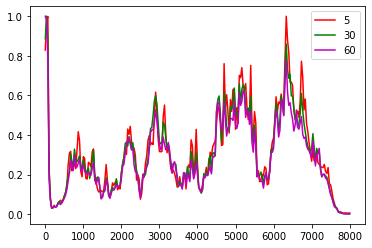

In [203]:
plt.plot(f,tf_atr1,'r',label='5')
#plt.plot(f,tf_atr2,'b',label='15')
plt.plot(f,tf_atr3,'g',label='30')
#plt.plot(f,tf_atr4,'k',label='45')
plt.plot(f,tf_atr5,'m',label='60')
#plt.plot(f,tf_atr6,'c',label='120')
#plt.plot(f,tf_atr7,'y',label='240')
# plt.plot(f,tf_atr8,'w',label='300')
plt.legend()
plt.show()

In [168]:
new_tf = np.concatenate((f.reshape(-1,1),
                         tf_atr1.reshape(-1,1),
                         tf_atr2.reshape(-1,1),
                         tf_atr3.reshape(-1,1),
                         tf_atr4.reshape(-1,1),
                         tf_atr5.reshape(-1,1),
                         tf_atr6.reshape(-1,1),
                         tf_atr7.reshape(-1,1),
                         tf_atr8.reshape(-1,1)),
                         axis=1)
np.savetxt("atr-tf-diff-length.csv", new_tf, delimiter=",",fmt='%.4e')

In [169]:
audio_dir = '/data1/wenjie/github/honk/speech_dataset_wenjie/meetingroom/loc2-45cm-10cmd/yes/convert/aligned/ATR-yes/0cb74144_nohash_0.wav'

In [192]:
y,sr = librosa.load(audio_dir,sr=16000)
print(y.shape,sr)
S = librosa.feature.melspectrogram(y=y,
                                   sr=sr,
                                   n_mels=40,
                                   hop_length=160,
                                   fmin=20,
                                   fmax=4000,
                                  n_fft=480)
mfcc = librosa.feature.mfcc(S=librosa.power_to_db(S))
print(mfcc.shape)
import matplotlib.pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
fig = plt.Figure()
canvas = FigureCanvas(fig)
ax = fig.add_subplot(111)
p=librosa.display.specshow(mfcc, sr=16000,hop_length=160,ax=ax)
# plt.colorbar()
plt.show()
fig.savefig('mfcc.svg')

(16000,) 16000
(20, 101)


(22050,) 22050
